In [1]:
# Imports, parameters
import collections
import geopandas as gpd
# import igraph as ig
import matplotlib.pyplot as plt
import multiprocessing as mp
import networkx as nx
import numpy as np
import os
import osmnx as ox
import pandas as pd
import rasterio
from collections import Counter
from descartes import PolygonPatch
from matplotlib import cm
from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from rasterio.features import shapes
from scipy.stats import pearsonr
from shapely.geometry import Point, LineString, Polygon

from config import rpath
os.chdir(rpath)

In [31]:
# Custom functions
def round_next_order(no):
    for i in range(2, 10):
        if np.round(no,i) == 0:
            next
        else:
            return(np.round(no, i))

At first, we get the graph.

In [2]:
B = ox.io.load_graphml(filepath="data/graphs/berlin-2851.graphml")

If we wanted to convert our graph to a GeoDataFrame, we'd run the following two lines:

In [89]:
edges_df = ox.graph_to_gdfs(B, nodes=False)
edges_df.head()

osmid             name  \
u      v         key                                                   
172539 34694265  0                          4610047  Holländerstraße   
       34694336  0                          5117633   Gotthardstraße   
       172562    0    [31740296, 33231778, 4804202]   Gotthardstraße   
172545 271370539 0                         24973218      Teichstraße   
       28345515  0                          4546470      Teichstraße   

                        highway maxspeed  oneway   length  \
u      v         key                                        
172539 34694265  0     tertiary       50   False  237.653   
       34694336  0    secondary       50   False  687.484   
       172562    0    secondary       50   False  436.809   
172545 271370539 0     tertiary       50   False   17.179   
       28345515  0     tertiary       50   False  171.849   

                                                               geometry  \
u      v         key                                                      
172539 34694265  0    LINESTRING (13.33550 52.56521, 13.33560 52.565...   
       34694336  0    LINESTRING (13.33550 52.56521, 13.33565 52.565...   
       172562    0    LINESTRING (13.33550 52.56521, 13.33533 52.565...   
172545 271370539 0    LINESTRING (13.34661 52.56703, 13.34664 52.56688)   
       28345515  0    LINESTRING (13.34661 52.56703, 13.34659 52.567...   

                      grade  grade_abs lanes  ref bridge tunnel junction  \
u      v         key                                                       
172539 34694265  0    0.000      0.000   NaN  NaN    NaN    NaN      NaN   
       34694336  0   -0.003      0.003   NaN  NaN    NaN    NaN      NaN   
       172562    0   -0.005      0.005     2  NaN    NaN    NaN      NaN   
172545 271370539 0    0.000      0.000   NaN  NaN    NaN    NaN      NaN   
       28345515  0    0.023      0.023   NaN  NaN    NaN    NaN      NaN   

                     width access service area est_width  
u      v         key                                      
172539 34694265  0     NaN    NaN     NaN  NaN       NaN  
       34694336  0     NaN    NaN     NaN  NaN       NaN  
       172562    0     NaN    NaN     NaN  NaN       NaN  
172545 271370539 0     NaN    NaN     NaN  NaN       NaN  
       28345515  0     NaN    NaN     NaN  NaN       NaN

In [ ]:
print("Number of Edges (undirected):", len(ox.graph_to_gdfs(B.to_undirected(), nodes=False)), "in Lämmer: 87,795.")
print("Number of Nodes (undirected):", len(ox.graph_to_gdfs(B.to_undirected(), edges=False)), "in Lämmer: 37,020.")

Number of Edges (undirected): 42585 in Lämmer: 87,795.


This is a manual check to see whether there are nodes with degree 2 left that are actually not road intersections. Taking a sample of these edges and entering them into https://www.openstreetmap.org/node/305293190 shows that they are actually intersections

In [34]:
# Get nodes with degree 2
for i, n in enumerate([node for (node, val) in B.degree() if val == 2]):
    print(n)
    print(B[n])
    if i == 4:
        break
# These nodes can checked via the osmid.

18244390
{18244392: {0: {'osmid': 4068164, 'name': 'Himbeersteig', 'highway': 'living_street', 'oneway': False, 'length': 46.122, 'geometry': <shapely.geometry.linestring.LineString object at 0x2b73fae6c130>, 'grade': -0.065, 'grade_abs': 0.065}}}
18244396
{18244397: {0: {'osmid': 4068188, 'name': 'Wasgensteig', 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'length': 167.469, 'geometry': <shapely.geometry.linestring.LineString object at 0x2b73fae6caf0>, 'grade': 0.036, 'grade_abs': 0.036}}}
18244410
{18244408: {0: {'osmid': 4068145, 'name': 'Quastheide', 'highway': 'living_street', 'oneway': False, 'length': 118.39599999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x2b73fae84670>, 'grade': 0.017, 'grade_abs': 0.017}}}
18244411
{18244407: {0: {'osmid': 4067937, 'name': 'Barkenhof', 'highway': 'living_street', 'oneway': False, 'length': 96.897, 'grade': -0.01, 'grade_abs': 0.01}}}
18244412
{18244406: {0: {'osmid': 4068190, 'name': 'Widenhof', 'high

# Common Measures
At first, we look at the average degree and degree distribution. If we look at the pure degree of the directed version, we get a very high average, but for a correct result, we actually have to look at the in- or outdegree (identical). Prior research looked at the undirected version, which we do, too.

In [35]:
H = B.to_undirected()

# Average degree 
degree_list = [degree for (node, degree) in B.degree()] # Non-normalized (directed edges = undirected edges * 2)
print(sum(degree_list)/len(degree_list))
# print(2*len(G.edges())/len(G.nodes())) # alternative with same result

degree_list = [degree for (node, degree) in B.in_degree()] # Normalized (avg. out-degree = avg. in-degree = avg. degree / 2)
print(sum(degree_list)/len(degree_list))
# print(len(G.edges())/len(G.nodes())) # alternative with same result

degree_list = [degree for (node, degree) in H.degree()] # undirected
print(sum(degree_list)/len(degree_list))
# print(2*len(H.edges())/len(H.nodes())) # alternative with same result

5.1906559864497686
2.5953279932248843
3.005398920215957


Here, we plot the degree distribution of the undirected graph and compare it with the plotted degree distribution when looking at the streets per node property of the graph

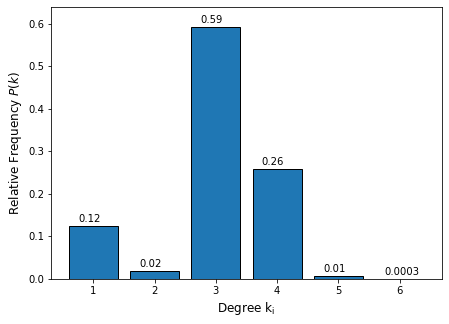

In [48]:
def plot_deg_distn(G, degree_sequence=None, type=None):
    if degree_sequence is None:
        if type == "in":
            degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
        elif type == "out":
            degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
        else:
            degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence # undirected graph

    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    total = sum([count for key, count in degreeCount.items()])
    freq = [c/total for c in cnt]

    fig, ax = plt.subplots(figsize=(7,5))
    plt.bar(deg, freq, width=0.80, edgecolor="k")

    plt.ylabel("Relative Frequency $P(k)$", fontsize=12)
    plt.xlabel("Degree $\mathregular{k_i}$", fontsize=12)
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)
    for i, v in enumerate(freq):
        s = round_next_order(v)
        ax.text(deg[i]-0.25, v+0.01, str(s), color='black', fontsize=10)    
    plt.margins(y=0.08)
    plt.show()
    return None

plot_deg_distn(H)

# B.graph

Below I've examined nodes with degree 6 and above. It seems to me that those are rather artifacts

In [15]:
print([(n,d) for n, d in H.degree() if d >= 5][:20])
# H[26646276]

[(172562, 5), (20246103, 5), (20246107, 5), (21441721, 5), (21487236, 5), (21537951, 5), (21538141, 5), (25661372, 5), (25661969, 5), (25663747, 5), (25664680, 5), (26570024, 5), (26583758, 5), (26602511, 5), (26627346, 5), (26627377, 5), (26646276, 6), (26662416, 5), (26682650, 5), (26702187, 5)]


In [16]:
# How many nodes and edges are there?
print(len(H.nodes))
print(len(H.edges))

28339


42585

In [23]:
G.graph["streets_per_node"]

'{172539: 3, 172545: 4, 172546: 3, 172547: 3, 172549: 3, 172558: 4, 172562: 5, 172564: 4, 172566: 3, 172586: 3, 172587: 4, 172589: 3, 172594: 4, 458330: 3, 458334: 3, 458350: 3, 458356: 3, 458362: 3, 458365: 3, 484078: 4, 484082: 3, 484102: 3, 484107: 3, 484110: 3, 484119: 3, 484121: 4, 484243: 3, 484245: 3, 484282: 3, 484285: 3, 484310: 3, 484322: 3, 530161: 4, 530168: 4, 530176: 4, 530177: 4, 530190: 4, 530197: 4, 530199: 3, 530202: 4, 530205: 3, 530215: 4, 530225: 4, 530247: 4, 530256: 4, 530262: 4, 530283: 4, 530284: 3, 530287: 3, 530293: 3, 530309: 3, 530311: 4, 530312: 4, 530313: 3, 530318: 4, 530319: 4, 530323: 3, 530340: 4, 530351: 4, 530376: 3, 530380: 3, 9671172: 3, 12614600: 4, 12614606: 3, 12614629: 3, 12614635: 4, 12614644: 4, 12614650: 4, 12614651: 3, 12614653: 4, 12614667: 3, 12614668: 4, 12614672: 3, 12614675: 3, 12614678: 3, 12614681: 4, 12614682: 3, 12614683: 4, 12615161: 3, 12615171: 4, 12615173: 4, 12615195: 4, 12696810: 3, 16541457: 4, 16541459: 4, 16541461: 3, 165

In [10]:
# Identify Dead ends
from ast import literal_eval
G = ox.io.load_graphml(filepath="data/graphs/berlin_raw.graphml")
streets_per_node = literal_eval(G.graph['streets_per_node'])
node_ids = set(G.nodes())
dead_ends = [node for node, count in streets_per_node.items() if count==1 and node in B.nodes()]
print("Fraction of tree-like structures:", len(dead_ends)/len(B.nodes()))

Fraction of tree-like structures: 0.10988390557182681


In [35]:
# Identify Dead ends
B.graph

{'created_date': '2021-01-04 20:48:52',
 'created_with': 'OSMnx 1.0.0',
 'crs': 'epsg:4326',
 'simplified': True}

In [11]:
# Total length of network
lT = np.sum(list(nx.get_edge_attributes(B,'length').values()))
mu = 1.51
beta = .49
print("Total length of the network:", lT)
print("Expected length according to Barthelemy:", mu*(len(B.nodes())**beta))

Total length of the network: 10523284.427000001
Expected length according to Barthelemy: 229.42744184227558


In [43]:
# r_N
degree_sequence = sorted([d for n, d in H.degree()], reverse=True)  # degree sequence # undirected graph
degreeCount = collections.Counter(degree_sequence)
r_N = (degreeCount[1]+degreeCount[3]) / (sum(degreeCount.values()) - degreeCount[2])
r_N

0.7296171252065226

In [44]:
# Compactness
berlin_uc = gpd.read_file("data/geodata/GHS/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")
berlin_uc = berlin_uc[berlin_uc.UC_NM_MN=="Berlin"].set_crs(4326).to_crs(25833)
A = berlin_uc.area # m^2
Psi = 1 - (4*A)/((lT-2*np.sqrt(A))**2)
Psi

2850    0.999975
dtype: float64

## Centrality
### Betweenness Centrality
At first, we calculate the (weighted?) betweenness centrality and save it for later usage (because it takes so long).

In [14]:
from networkx.algorithms.centrality import edge_betweenness_centrality

K = int(round(len(B.nodes())/10,0)) # Sample for calculating centrality

In [27]:
H = B.to_undirected()

In [ ]:
# Takes forever
edge_betweenness = edge_betweenness_centrality(H, k=K)
edge_betweenness_weighted = edge_betweenness_centrality(H, k=K, weight="length")

node_betweenness = nx.betweenness_centrality(nx.Graph(H), k=K) # convert H to graph (instead of multigraph)
node_betweenness_weighted = nx.betweenness_centrality(H, k=K, weight="length")

node_closeness = nx.closeness_centrality(H, distance="length") # Weighted by length

# Save
with open(r'data/berlin_uc_edge_betweenness.json','w+') as f:
     f.write(str(edge_betweenness))
with open(r'data/berlin_uc_edge_betweenness_weighted.json','w+') as f:
     f.write(str(edge_betweenness_weighted))
with open(r'data/berlin_uc_node_betweenness.json','w+') as f:
     f.write(str(node_betweenness))
with open(r'data/berlin_uc_node_betweenness_weighted.json','w+') as f:
     f.write(str(node_betweenness_weighted))
with open(r'data/berlin_uc_node_closeness.json','w+') as f:
     f.write(str(node_closeness))

In [59]:
# Read Centralities (NOTE: UNDIRECTED VERSIONS)
dic = ''
with open(r'data/berlin_uc_edge_betweenness.json','r') as f:
         for i in f.readlines():
            dic = i #string
edge_betweenness = eval(dic)

dic = ''
with open(r'data/berlin_uc_edge_betweenness_weighted.json','r') as f:
         for i in f.readlines():
            dic = i #string
edge_betweenness_weighted = eval(dic)

dic = ''
with open(r'data/berlin_uc_node_betweenness.json','r') as f:
         for i in f.readlines():
            dic = i #string
node_betweenness = eval(dic)

dic = ''
with open(r'data/berlin_uc_node_betweenness_weighted.json','r') as f:
         for i in f.readlines():
            dic = i #string
node_betweenness_weighted = eval(dic)

dic = ''
with open(r'data/berlin_uc_node_closeness.json','r') as f:
         for i in f.readlines():
            dic = i #string
node_closeness = eval(dic)

dic = ''
with open(r'data/berlin_uc_node_straightness.json','r') as f:
         for i in f.readlines():
            dic = i #string
node_straightness = eval(dic)


Now we add the betweenness to the graph with a small workaround

In [50]:
multi_edge_betweenness = dict()
multi_edge_betweenness_weighted = dict()

for key in edge_betweenness.keys():
    new_key = (key[0],key[1],0)
    multi_edge_betweenness[new_key] = edge_betweenness[key]
    
for key in edge_betweenness_weighted.keys():
    new_key = (key[0],key[1],0)
    multi_edge_betweenness_weighted[new_key] = edge_betweenness_weighted[key]

In [51]:
nx.set_edge_attributes(H, multi_edge_betweenness, name="betweenness")
nx.set_edge_attributes(H, multi_edge_betweenness_weighted, name="betweenness_weighted")
nx.set_node_attributes(H, node_betweenness, name="betweenness")
nx.set_node_attributes(H, node_betweenness_weighted, name="betweenness_weighted")
nx.set_node_attributes(H, node_closeness, name="closeness")

H_edges = ox.graph_to_gdfs(H, nodes=False).reset_index()

# Set lw attribute
print(np.quantile(H_edges.betweenness_weighted.dropna()*10000, np.arange(0,1.01,.05)))
lw = H_edges.betweenness_weighted*10000
lw[lw > 5] = 5
H_edges["lw"] = lw
# Discrete attribute
H_edges["lw2"] = pd.qcut(H_edges.betweenness_weighted, 10, labels=np.logspace(-5,2,base=2, num=10)).astype(float)


[0.00000000e+00 7.84004643e-03 1.87911338e-02 2.97158089e-02
 3.50280544e-02 3.50654110e-02 4.89888014e-02 6.65222765e-02
 8.66238617e-02 1.12730731e-01 1.50219425e-01 2.01364225e-01
 2.66886100e-01 3.59774450e-01 4.55508213e-01 6.08272252e-01
 8.75772926e-01 1.38453211e+00 2.63477489e+00 6.80633175e+00
 1.83272450e+02]


Here, we recreate the betweenness Plot of Lämmer with the Betweenness.

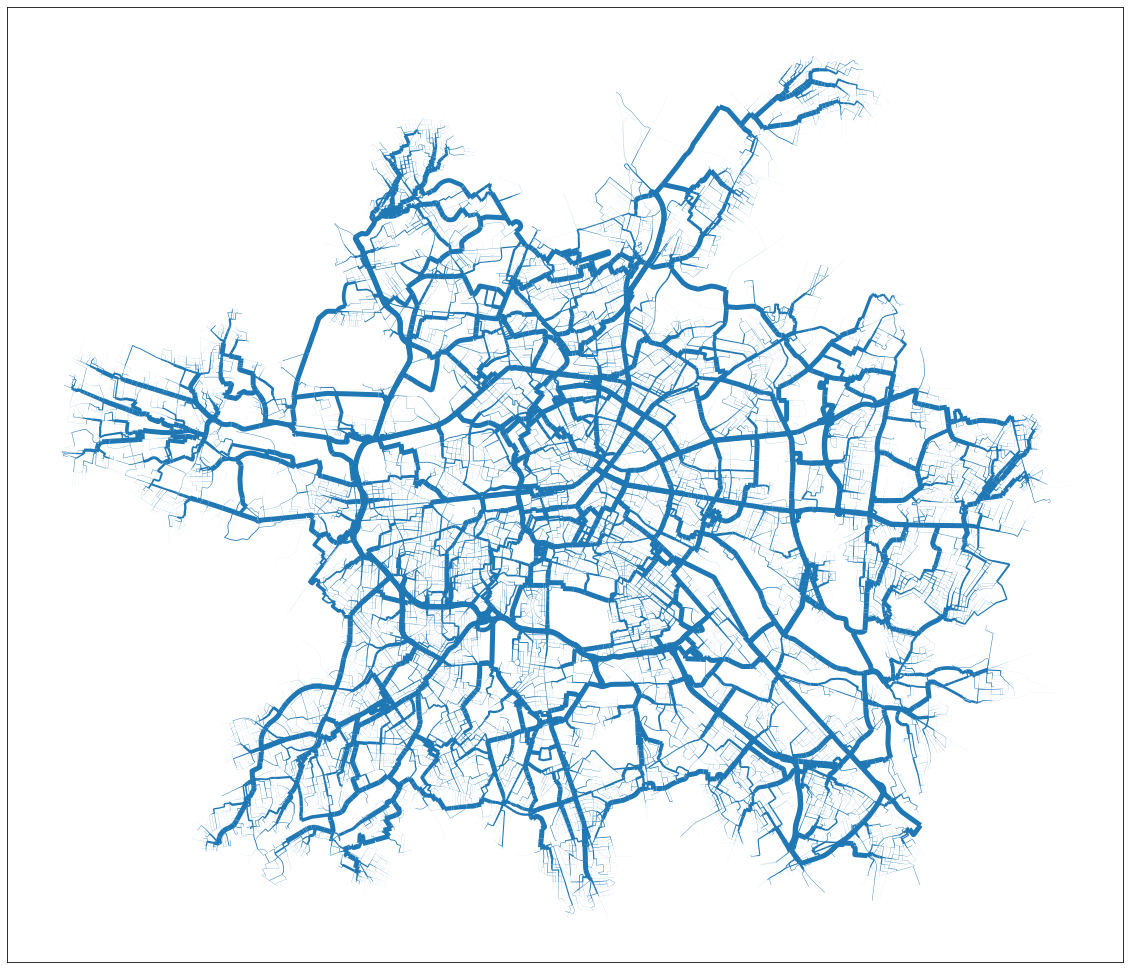

In [54]:
fig, ax = plt.subplots(figsize=(20,20))
H_edges.plot(ax=ax, linewidth=H_edges["lw"]) # lw2: Using the discretization
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.show()

While the above gives us the theoretical centrality, we now compare it with the actual traffic happening on the edges.

In [22]:
# Get Waypoint Files
path = "data/Berlin_2017/data/waypoints"
files = []
for file in os.listdir(path):
    if file.endswith("edges.csv"):
        files.append(os.path.join(path,file))
files.sort()
keepcols = ['TripID', 'edge_1', 'edge_2', 'edge_dist']

In [58]:
def read_files_make_counter(file):
    '''Reads a "with_edges" waypoint file, gets the total count on the edges and returns a counter for it.'''
    df = pd.read_csv(file)[keepcols]
    df = df[df["edge_dist"]<=50] 
    df.drop(columns="edge_dist", inplace=True)
    df = df.groupby(["edge_1", "edge_2"]).agg('count').reset_index()
    
    counts = collections.Counter()
    for i in range(len(df)):
        counts[(df.edge_1.iloc[i], df.edge_2.iloc[i], 0)] =  df.TripID.iloc[i]
    return counts

pool = mp.Pool(processes=min(len(files), 7))
counts_list = pool.map(read_files_make_counter, files)
pool.close()

traffic_n = sum(counts_list, collections.Counter())

with open(r'data/berlin_uc_traffic_n.json','w+') as f:
     f.write(str(traffic_n))

In [56]:
dic = ''
with open(r'data/berlin_uc_traffic_n.json','r') as f:
         for i in f.readlines():
            dic = i #string
traffic_n = eval(dic)

traffic_n_new = dict()
for key in traffic_n.keys():
    new_key = (key[0],key[1],0)
    traffic_n_new[new_key] = traffic_n[key]
nx.set_edge_attributes(H, traffic_n_new, name="traffic_n")

In [57]:
H_edges = ox.graph_to_gdfs(H, nodes=False).reset_index()
print(np.quantile(H_edges.traffic_n.dropna()/10000,np.arange(0,1.01,.1)))
n_lw = H_edges.traffic_n.dropna()/10000
n_lw[n_lw > 5] = 5
H_edges["n_lw"] = n_lw

H_edges["n_lw2"] = pd.qcut(H_edges.traffic_n, 10, labels=np.logspace(-5,2,base=2, num=10)).astype(float)

[1.000000e-04 4.300000e-03 1.300000e-02 2.800000e-02 5.380000e-02
 9.930000e-02 1.922000e-01 4.047600e-01 1.013640e+00 3.185320e+00
 5.810173e+02]


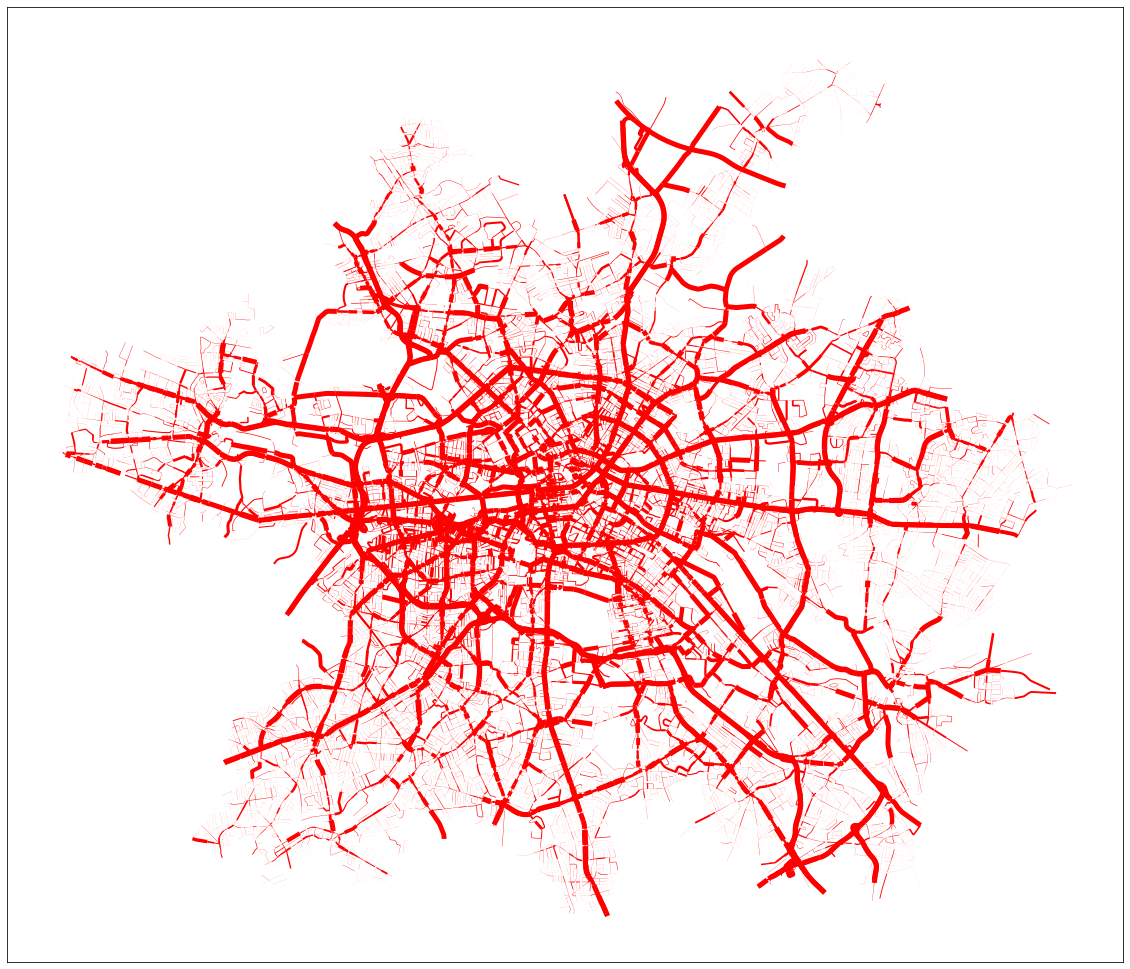

In [62]:
fig, ax = plt.subplots(figsize=(20,20))
H_edges.plot(ax=ax, linewidth=H_edges["n_lw2"], color="red") # n_lw for undiscretized version
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.show()

There is an obvious correlation between betweenness and n. Let's check this out more closely.

In [87]:
pearsonr(H_edges.dropna(subset=["betweenness", "traffic_n"]).betweenness, H_edges.dropna(subset=["betweenness", "traffic_n"]).traffic_n)

(0.43100084912384407, 0.0)

In [60]:
nx.set_node_attributes(H, node_betweenness, name="betweenness")
nx.set_node_attributes(H, node_betweenness_weighted, name="betweenness_weighted")

In [173]:
np.quantile(H_nodes.betweenness_weighted,np.arange(0,1.01,.1))*100

array([0.00000000e+00, 0.00000000e+00, 3.48425009e-03, 9.89412460e-03,
       2.57650207e-02, 5.35065253e-02, 1.08325061e-01, 2.38403648e-01,
       5.61470837e-01, 1.22790054e+00, 7.50180088e+00])

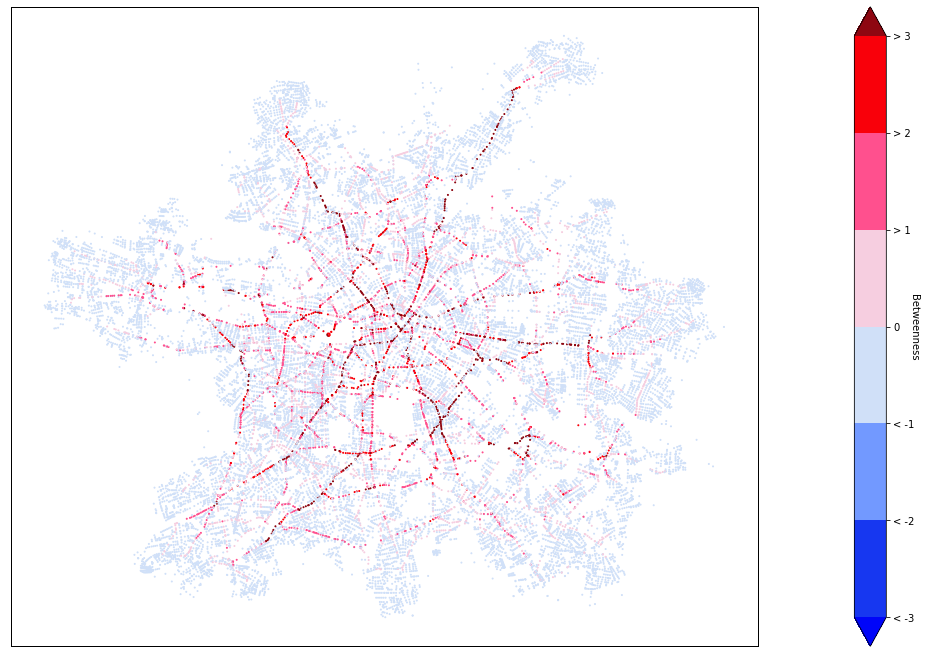

In [82]:
# Plot the nodes
fig, ax = plt.subplots(figsize=(20,20))

cmap = cm.bwr 
cmap = mcolors.ListedColormap(['#0005f9', '#1737f0', '#7299ff', '#d0e0f8', 
                               '#f6cee0', '#ff508e', '#f9000a', '#8e0711'])

bounds = [np.mean(H_nodes.betweenness_weighted) - 3*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) - 2*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) - 1*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) + 1*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) + 2*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) + 3*np.std(H_nodes.betweenness_weighted)]
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')

# norm = mcolors.Normalize(vmin=H_nodes.betweenness_weighted.min(), vmax=H_nodes.betweenness_weighted.max())
H_nodes['color'] = H_nodes.betweenness_weighted.apply(lambda x: cmap(norm(x)))
H_nodes.plot(ax=ax, color=H_nodes.color, markersize=1)

# Colorbar
# for making the colorbar the right size
aspect = 20
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
cax = divider.append_axes("right", size=width, pad=-2)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, 
                    orientation='vertical', extend="both",
                    ticks = bounds)

cbar.ax.set_yticklabels(['< -3', '< -2', '< -1', '0', '> 1', '> 2', '> 3']) 
cbar.ax.set_ylabel('Betweenness', rotation=270)

ax.set_facecolor("white")
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 

ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [13]:
H_nodes.sort_values("betweenness", ascending=False).head()

osmid          y          x  street_count  elevation  \
25719  2302008843  52.461568  13.408974             3       51.0   
3083     26908981  52.474267  13.358883             3       39.0   
15         458350  52.532169  13.286642             3       40.0   
14923   205325342  52.470171  13.376730             3       46.0   
322      21487279  52.469346  13.389534             3       51.0   

      elevation_aster elevation_srtm  betweenness  betweenness_weighted  \
25719              51             52     0.185125              0.002463   
3083               43             39     0.182003              0.003503   
15                 44             40     0.178931              0.000377   
14923              46             45     0.178745              0.002404   
322                51             46     0.178507              0.004848   

       closeness  ref            highway                   geometry  \
25719   0.000078  NaN                NaN  POINT (13.40897 52.46157)   
3083    0.000081  NaN                NaN  POINT (13.35888 52.47427)   
15      0.000071    4  motorway_junction  POINT (13.28664 52.53217)   
14923   0.000081   19  motorway_junction  POINT (13.37673 52.47017)   
322     0.000082   20  motorway_junction  POINT (13.38953 52.46935)   

                                                   color  
25719  (0.8156862745098039, 0.8784313725490196, 0.972...  
3083   (0.8156862745098039, 0.8784313725490196, 0.972...  
15     (0.8156862745098039, 0.8784313725490196, 0.972...  
14923  (0.8156862745098039, 0.8784313725490196, 0.972...  
322    (0.9647058823529412, 0.807843137254902, 0.8784...

### Closeness centrality

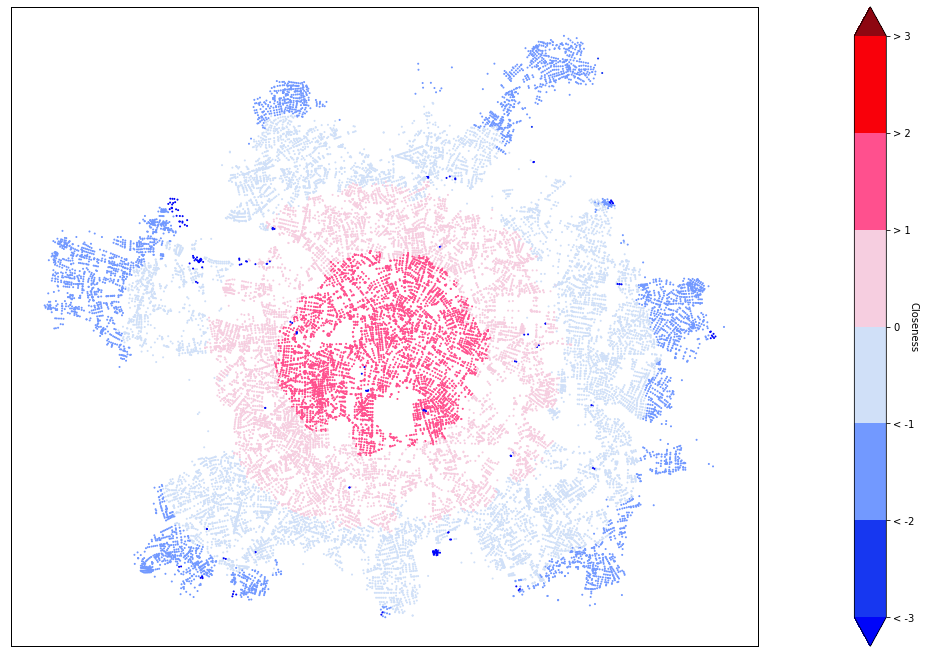

In [83]:
# Plot the nodes
fig, ax = plt.subplots(figsize=(20,20))

bounds = [np.mean(H_nodes.closeness) - 3*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness) - 2*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness) - 1*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness),
          np.mean(H_nodes.closeness) + 1*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness) + 2*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness) + 3*np.std(H_nodes.closeness)]
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')

# norm = mcolors.Normalize(vmin=H_nodes.betweenness_weighted.min(), vmax=H_nodes.betweenness_weighted.max())
H_nodes['color'] = H_nodes.closeness.apply(lambda x: cmap(norm(x)))
H_nodes.plot(ax=ax, color=H_nodes.color, markersize=1)

# Colorbar
# for making the colorbar the right size
aspect = 20
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
cax = divider.append_axes("right", size=width, pad=-2)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, 
             orientation='vertical', label='Betweenness',
             extend="both", ticks = bounds)

cbar.ax.set_yticklabels(['< -3', '< -2', '< -1', '0', '> 1', '> 2', '> 3']) 
cbar.ax.set_ylabel('Closeness', rotation=270)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [29]:
H_nodes.sort_values("closeness")

osmid          y          x  street_count  elevation  \
14415   162357974  52.498495  13.379339             1       38.0   
22659  1423093633  52.495162  13.377168             1       36.0   
27827  6294211804  52.547869  13.247225             1       36.0   
26704  3776625290  52.549794  13.237056             1       34.0   
13792   144309597  52.549416  13.279172             1       32.0   
...           ...        ...        ...           ...        ...   
27033  4451098200  52.511441  13.401579             3       37.0   
18349   283038326  52.511170  13.401154             4       36.0   
18348   283038325  52.511338  13.401125             4       37.0   
18357   283045467  52.511208  13.401312             4       35.0   
323      21487284  52.511327  13.401721             3       37.0   

      elevation_aster elevation_srtm  betweenness  betweenness_weighted  \
14415              38             40     0.000000              0.000000   
22659              45             36     0.000000              0.000000   
27827              40             36     0.000000              0.000000   
26704              25             34     0.000000              0.000000   
13792              35             32     0.000000              0.000000   
...               ...            ...          ...                   ...   
27033              37             34     0.004815              0.029837   
18349              36             43     0.000374              0.051074   
18348              37             37     0.005242              0.029912   
18357              35             44     0.000818              0.050038   
323                37             34     0.008008              0.050827   

          closeness  ref highway                   geometry  \
14415  8.851685e-08  NaN     NaN  POINT (13.37934 52.49850)   
22659  8.851685e-08  NaN     NaN  POINT (13.37717 52.49516)   
27827  9.998472e-08  NaN     NaN  POINT (13.24723 52.54787)   
26704  1.075342e-07  NaN     NaN  POINT (13.23706 52.54979)   
13792  1.334225e-07  NaN     NaN  POINT (13.27917 52.54942)   
...             ...  ...     ...                        ...   
27033  8.992108e-05  NaN     NaN  POINT (13.40158 52.51144)   
18349  8.992190e-05  NaN     NaN  POINT (13.40115 52.51117)   
18348  8.992884e-05  NaN     NaN  POINT (13.40113 52.51134)   
18357  8.992947e-05  NaN     NaN  POINT (13.40131 52.51121)   
323    8.993107e-05  NaN     NaN  POINT (13.40172 52.51133)   

                                                   color  
14415  (0.8156862745098039, 0.8784313725490196, 0.972...  
22659  (0.8156862745098039, 0.8784313725490196, 0.972...  
27827  (0.8156862745098039, 0.8784313725490196, 0.972...  
26704  (0.8156862745098039, 0.8784313725490196, 0.972...  
13792  (0.8156862745098039, 0.8784313725490196, 0.972...  
...                                                  ...  
27033  (0.5568627450980392, 0.027450980392156862, 0.0...  
18349  (0.5568627450980392, 0.027450980392156862, 0.0...  
18348  (0.5568627450980392, 0.027450980392156862, 0.0...  
18357  (0.5568627450980392, 0.027450980392156862, 0.0...  
323    (0.5568627450980392, 0.027450980392156862, 0.0...  

[28339 rows x 14 columns]

### Straightness centrality 
Straightness is calculated offline but read in here.

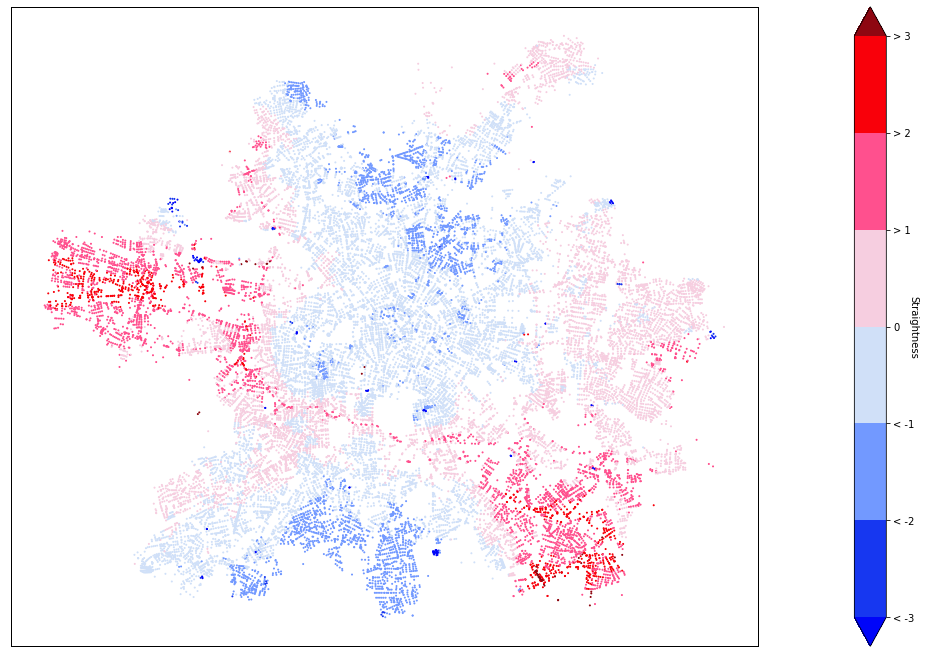

In [84]:
nx.set_node_attributes(H, node_straightness, name="straightness")
H_nodes = ox.graph_to_gdfs(H, edges=False).reset_index()

# Plot the nodes
fig, ax = plt.subplots(figsize=(20,20))

bounds = [np.mean(H_nodes.straightness) - 3*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness) - 2*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness) - 1*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness),
          np.mean(H_nodes.straightness) + 1*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness) + 2*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness) + 3*np.std(H_nodes.straightness)]
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')

# norm = mcolors.Normalize(vmin=H_nodes.betweenness_weighted.min(), vmax=H_nodes.betweenness_weighted.max())
H_nodes['color'] = H_nodes.straightness.apply(lambda x: cmap(norm(x)))
H_nodes.plot(ax=ax, color=H_nodes.color, markersize=1)

# Colorbar
# for making the colorbar the right size
aspect = 20
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
cax = divider.append_axes("right", size=width, pad=-2)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, 
             orientation='vertical', label='Betweenness',
             extend="both", ticks = bounds)

cbar.ax.set_yticklabels(['< -3', '< -2', '< -1', '0', '> 1', '> 2', '> 3']) 
cbar.ax.set_ylabel('Straightness', rotation=270)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1') 
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Everything at once

In [ ]:
nx.set_node_attributes(H, node_betweenness_weighted, name="betweenness_weighted")
nx.set_node_attributes(H, node_closeness, name="closeness")
nx.set_node_attributes(H, node_straightness, name="straightness")
H_nodes = ox.graph_to_gdfs(H, edges=False).reset_index()

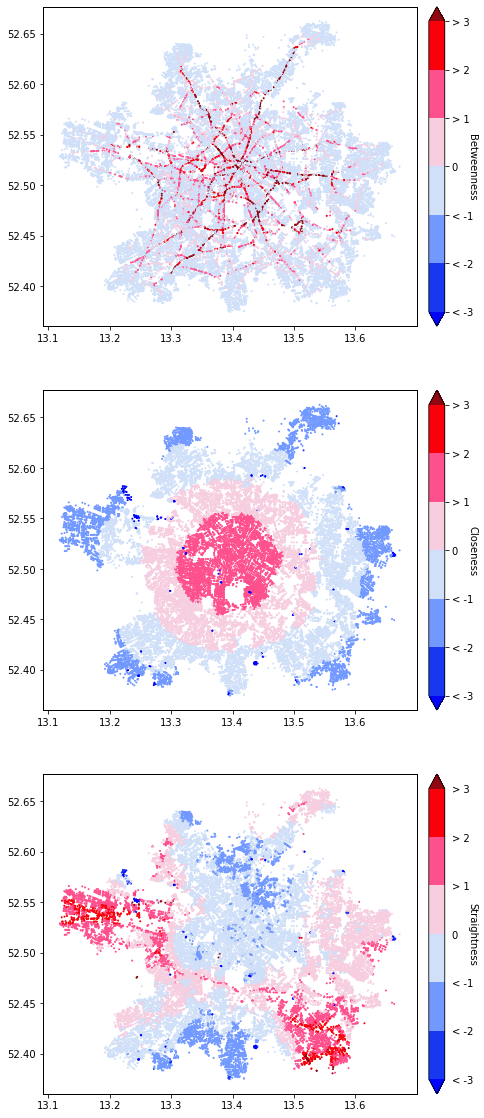

In [78]:
# Plot the nodes
fig, axes = plt.subplots(3,1,figsize=(60,20))

axes = axes.ravel()
cmap = cm.bwr 
cmap = mcolors.ListedColormap(['#0005f9', '#1737f0', '#7299ff', '#d0e0f8', 
                               '#f6cee0', '#ff508e', '#f9000a', '#8e0711'])

# Betweenness
bounds = [np.mean(H_nodes.betweenness_weighted) - 3*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) - 2*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) - 1*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) + 1*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) + 2*np.std(H_nodes.betweenness_weighted),
          np.mean(H_nodes.betweenness_weighted) + 3*np.std(H_nodes.betweenness_weighted)]
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
H_nodes['color'] = H_nodes.betweenness_weighted.apply(lambda x: cmap(norm(x)))
H_nodes.plot(ax=axes[0], color=H_nodes.color, markersize=1)

aspect = 20
divider = make_axes_locatable(axes[0])
width = axes_size.AxesY(axes[0], aspect=1./aspect)
cax = divider.append_axes("right", size=width, pad=-1.5)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, 
                    orientation='vertical', extend="both",
                    ticks = bounds)

cbar.ax.set_yticklabels(['< -3', '< -2', '< -1', '0', '> 1', '> 2', '> 3']) 
cbar.ax.set_ylabel('Betweenness', rotation=270)



## Closeness
bounds = [np.mean(H_nodes.closeness) - 3*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness) - 2*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness) - 1*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness),
          np.mean(H_nodes.closeness) + 1*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness) + 2*np.std(H_nodes.closeness),
          np.mean(H_nodes.closeness) + 3*np.std(H_nodes.closeness)]
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
H_nodes['color'] = H_nodes.closeness.apply(lambda x: cmap(norm(x)))
H_nodes.plot(ax=axes[1], color=H_nodes.color, markersize=1)
divider = make_axes_locatable(axes[1])
width = axes_size.AxesY(axes[1], aspect=1./aspect)
cax = divider.append_axes("right", size=width, pad=-1.5)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, 
             orientation='vertical', label='Betweenness',
             extend="both", ticks = bounds)

cbar.ax.set_yticklabels(['< -3', '< -2', '< -1', '0', '> 1', '> 2', '> 3']) 
cbar.ax.set_ylabel('Closeness', rotation=270)


## Straightness
bounds = [np.mean(H_nodes.straightness) - 3*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness) - 2*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness) - 1*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness),
          np.mean(H_nodes.straightness) + 1*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness) + 2*np.std(H_nodes.straightness),
          np.mean(H_nodes.straightness) + 3*np.std(H_nodes.straightness)]
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')

# norm = mcolors.Normalize(vmin=H_nodes.betweenness_weighted.min(), vmax=H_nodes.betweenness_weighted.max())
H_nodes['color'] = H_nodes.straightness.apply(lambda x: cmap(norm(x)))
H_nodes.plot(ax=axes[2], color=H_nodes.color, markersize=1)
divider = make_axes_locatable(axes[2])
width = axes_size.AxesY(axes[2], aspect=1./aspect)
cax = divider.append_axes("right", size=width, pad=-1.5)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, 
             orientation='vertical', label='Betweenness',
             extend="both", ticks = bounds)

cbar.ax.set_yticklabels(['< -3', '< -2', '< -1', '0', '> 1', '> 2', '> 3']) 
cbar.ax.set_ylabel('Straightness', rotation=270)


for ax in axes:
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('1')

plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.show()

# Isochrones
With code from https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb

In [8]:
G = ox.io.load_graphml(filepath="data/graphs/berlin_unsimplified.graphml")
travel_speed = 32.73  # avg. travel speed Berlin
trip_times = [5, 10, 15, 20, 25]  # in minutes

In [10]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
# x, y = gdf_nodes["geometry"].unary_union.centroid.xy
x, y = ([13.204977], [52.536510])  # Spandau
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G, 25833)

In [11]:
for _, _, _, data in G.edges(data=True, keys=True):
    if "maxspeed" in data:
        if type(data["maxspeed"]) == list:
            data["maxspeed"] = min(data["maxspeed"])
        if data["maxspeed"] == "DE:urban":
            data["maxspeed"] = 50
        if data["maxspeed"] == "none":
            data["maxspeed"] = travel_speed
        if data["maxspeed"] == "walk":
            data["maxspeed"] = 5
        data["maxspeed"] = int(data["maxspeed"]) 
    else:
        data["maxspeed"] = travel_speed
    data["maxspeed"] = data["maxspeed"]*1000/60 # meters_per_minute

In [12]:
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / data["maxspeed"] 

In [13]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

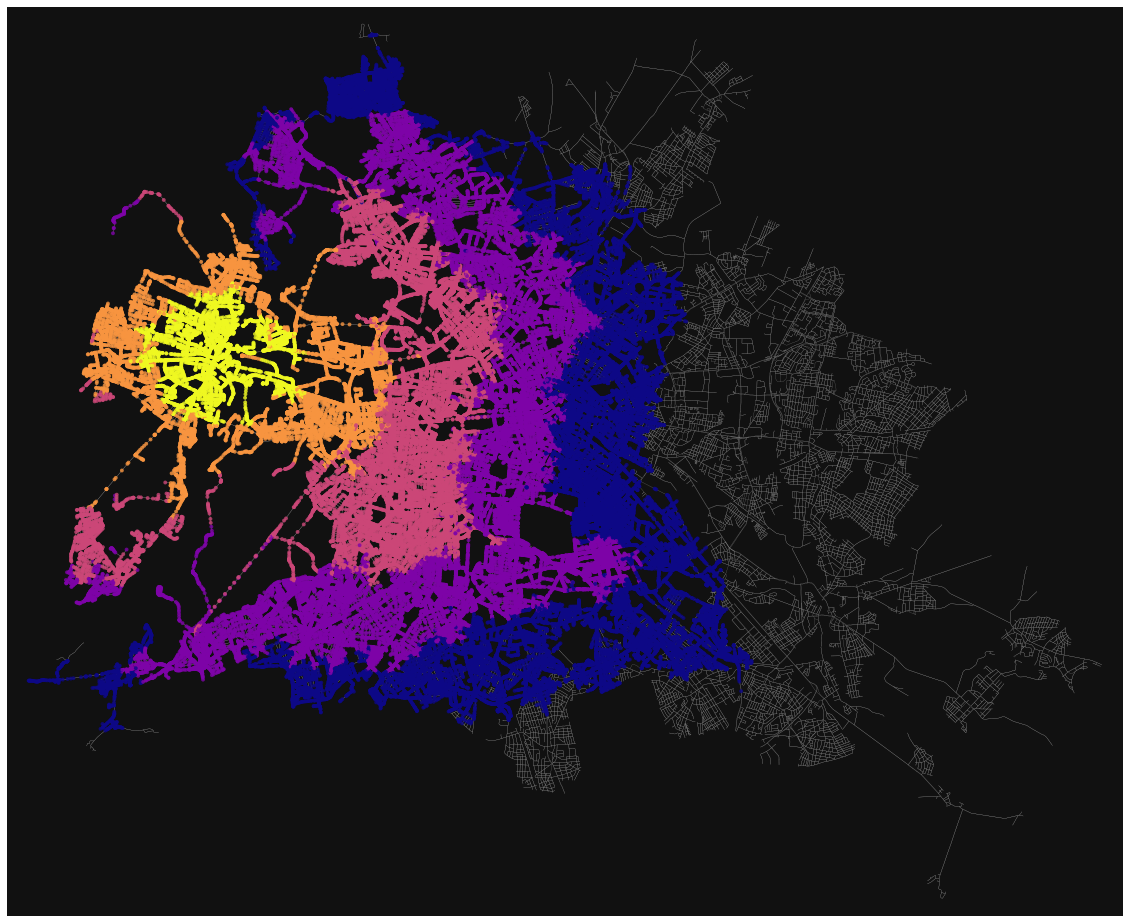

In [15]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
    figsize=(20,20)
)

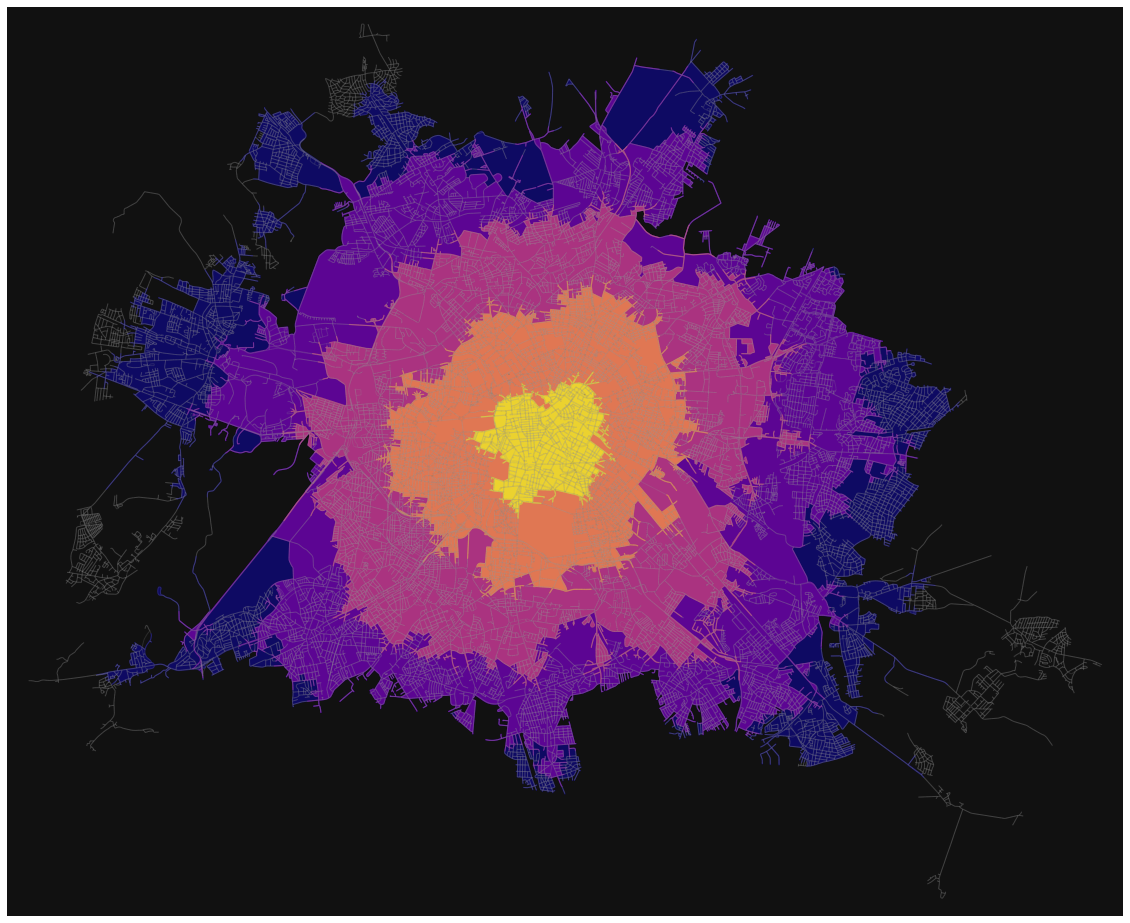

In [7]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0, figsize=(20,20)
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

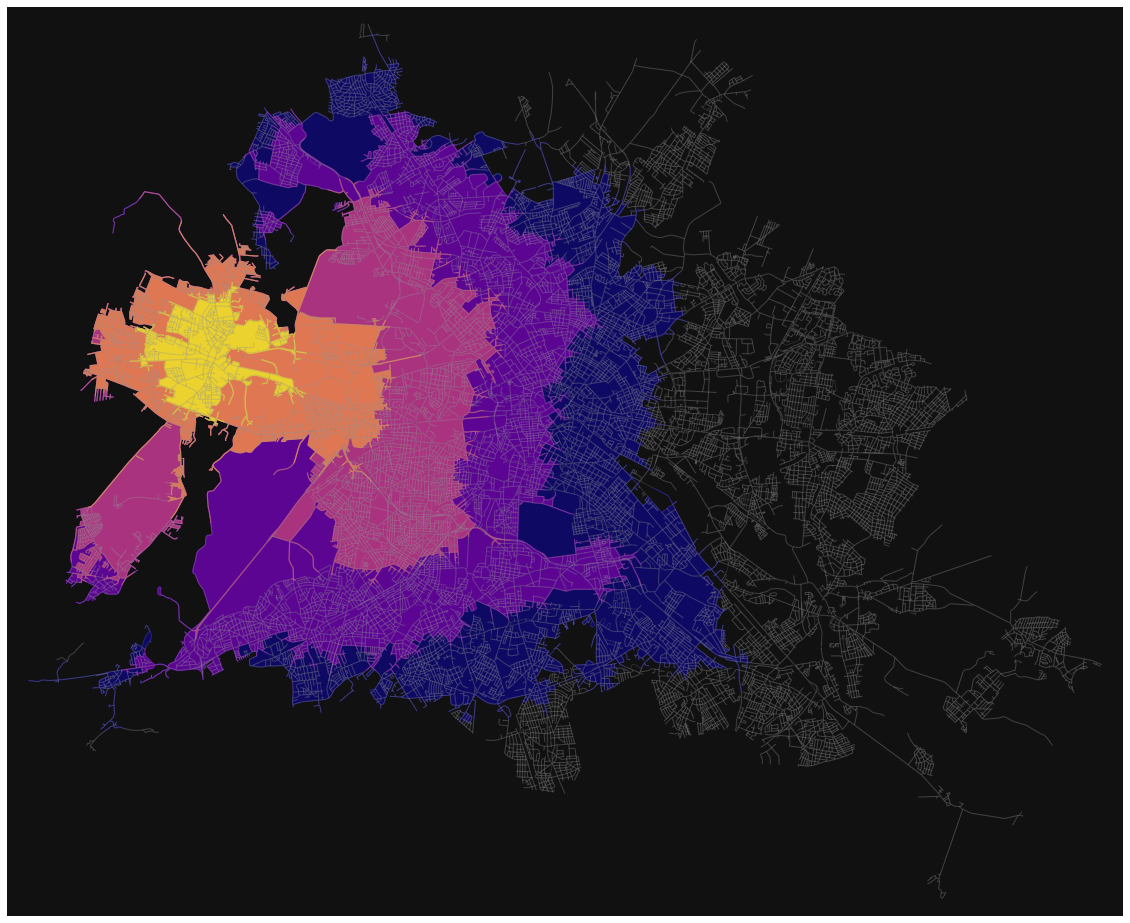

In [16]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0, figsize=(20,20)
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

# Community Detection

In [23]:
from networkx.algorithms.community import greedy_modularity_communities

In [18]:
B = ox.io.load_graphml(filepath="data/graphs/berlin-2851.graphml")

In [27]:
c = list(greedy_modularity_communities(nx.Graph(B)))

In [39]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(c), cmap="hsv", start=0, return_hex=True)

# color the nodes according to isochrone then plot the street network
node_colors = {}
for i, col in enumerate(iso_colors):
    for node in c[i]:
        node_colors[node] = col
    pass
      
nc = [node_colors[node] if node in node_colors else "none" for node in B.nodes()]
ns = [15 if node in node_colors else 0 for node in B.nodes()]

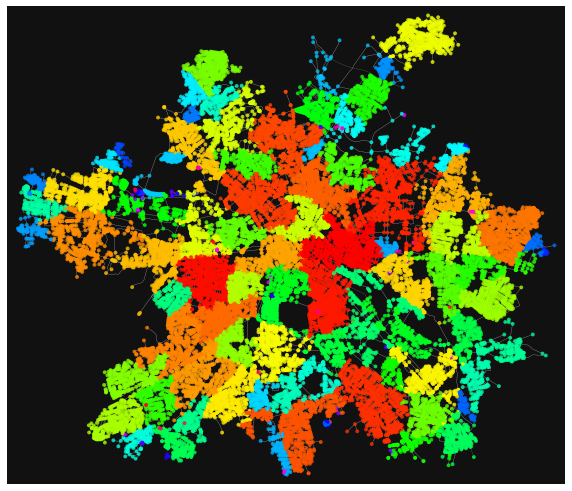

In [40]:
fig, ax = ox.plot_graph(
    B,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
    figsize=(10,10)
)